In [1]:
library(diann)
library(tidyverse)
library(gtools)
library(grid)
library(gridExtra)


# import plot functions
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/preprocessing_raw/preprocessing_DIANN.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# Paths to report files

In [2]:
path_to_reports <- '/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/00_raw_data'


lab_A_path <- file.path(path_to_reports, '/lab_A/', '2024-04-20_21-25-12_diann_run/report.tsv')
lab_B_path <- file.path(path_to_reports, '/lab_B/', '2024-04-25_15-05-38_diann_run/report.tsv')
lab_C_path <- file.path(path_to_reports, '/lab_C/', '2024-04-20_21-41-34_diann_run/report.tsv')
lab_D_path <- file.path(path_to_reports, '/lab_D/', '2024-04-20_21-45-56_diann_run/report.tsv')
lab_E_path <- file.path(path_to_reports, '/lab_E/', '2024-04-20_21-51-06_diann_run/report.tsv')

labs_list = list(lab_A = lab_A_path, lab_B = lab_B_path, lab_C = lab_C_path, lab_D = lab_D_path, lab_E = lab_E_path)

# Preprocessing - Client side 
Load data and prepare for the analysis 
    - QC plots
    - remove low-quality samples
    - save  to a new files with new names

Clients:
- use filter - Lib.Q.Value <= 0.01 & Lib.PG.Q.Value <= 0.01
- use column - PG.MaxLFQ
- check PCA
- plot boxplot
- plot hetmap

And also save user-specific metadata files to the new folder and peptide-counts.

## Metadata

In [3]:
create_metadata <- function(data, name) {
    # if(name == 'lab_A') {
    #   condition = c(rep("A", 4), rep("B", 4), rep("A", 9), rep("B", 10))
    # test like we didnt see S37 sample
    if(name == 'lab_A') {
      condition = c(rep("Pyr", 2), rep("Glu", 2), rep("Pyr", 10), rep("Glu", 10))
    } else if (name == 'lab_B') {
      condition = c(rep("Pyr", 12), rep("Glu", 11))
    } else if (name == 'lab_C') {
      condition = c(rep("Pyr", 11), rep("Glu", 12))
    } else if (name == 'lab_D') {
      condition = c(rep("Pyr", 10), rep("Glu", 10), rep("Pyr", 2), rep("Glu", 2))
    } else if (name == 'lab_E') {
      condition = c(rep("Glu", 1), rep("Pyr", 2), rep("Glu", 1), rep("Pyr", 10), rep("Glu", 10))
    } else {
      stop('Wrong lab name')
    }
    batch_info <- data.frame(
        file = c(gtools::mixedsort(unique(data$File.Name))),
        lab = as.factor(c(rep(name, length(unique(data$File.Name))))),
        condition = as.factor(condition)
    )
    rownames(batch_info) <- batch_info$file
    return(batch_info)
}

## Preprocessing

In [4]:
rename_samples <- function(pg_matrix, metadata, name){
    # rename
    if (name == 'lab_A' | name == 'lab_E'){
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          if (length(x) == 4) {  # if there are four parts
            paste(x[2], x[4], sep = "_")
          } else {  # otherwise, there are three parts
            x[2]
          }
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    }
    else if (name == 'lab_C') {
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          paste(x[5], x[6], sep = "_")
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    
    } else if (name == 'lab_B') {
        metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          x[5]
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    
    } else if (name == 'lab_D') {
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          x[8]
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    }

    return(list(pg_matrix, metadata))
}


create_plots <- function(pg_matrix, metadata, name, plot_file_prefix){

    # log2 transform for plots
    pg_matrix <- pg_matrix %>% 
      mutate(across(everything(), 
                      ~ {.x <- log2(.)
                      replace(.x, .x < 0 | is.infinite(.x), NA)
                      }))
    
    # metadata_with_ref_samples <- create_metadata_with_ref(data, name)
    renaming_res <- rename_samples(pg_matrix, metadata, name)
    pg_matrix <- renaming_res[[1]]
    metadata <- renaming_res[[2]]

    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, title=paste0(name, " PCA"), quantitative_col_name='file', col_col='condition', shape_col='lab')
    plot_boxplot <- boxplot_pg(pg_matrix, metadata, title=paste0(name, " Boxplot"), color_col='condition', quantitativeColumnName='file')
    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, title=paste0(name, " Density"), poolColumnName='condition', quantitativeColumnName='file')
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = 11, height = 10)
}

Number of proteins:  2549    Numer of samples:  24 
Filtering out features that have NAs in all columns
	Before filtering: 2549 24 
	After filtering: 2549 24 


`summarise()` has grouped output by 'Run'. You can override using the `.groups`
argument.
No id variables; using all as measure variables



Number of proteins:  2846    Numer of samples:  23 
Filtering out features that have NAs in all columns
	Before filtering: 2846 23 
	After filtering: 2846 23 


`summarise()` has grouped output by 'Run'. You can override using the `.groups`
argument.
No id variables; using all as measure variables



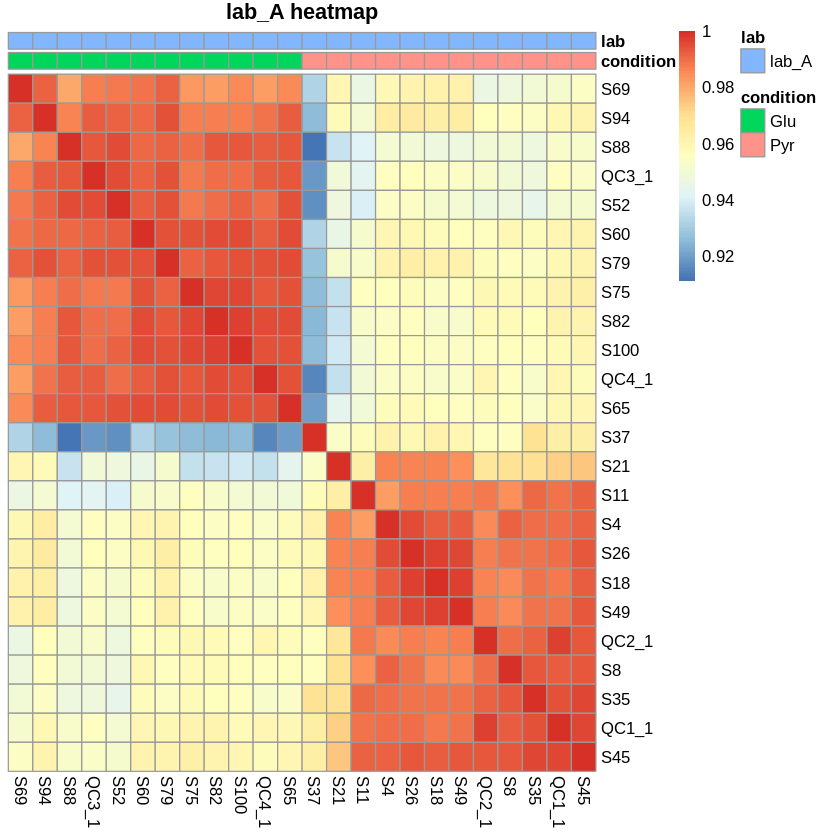

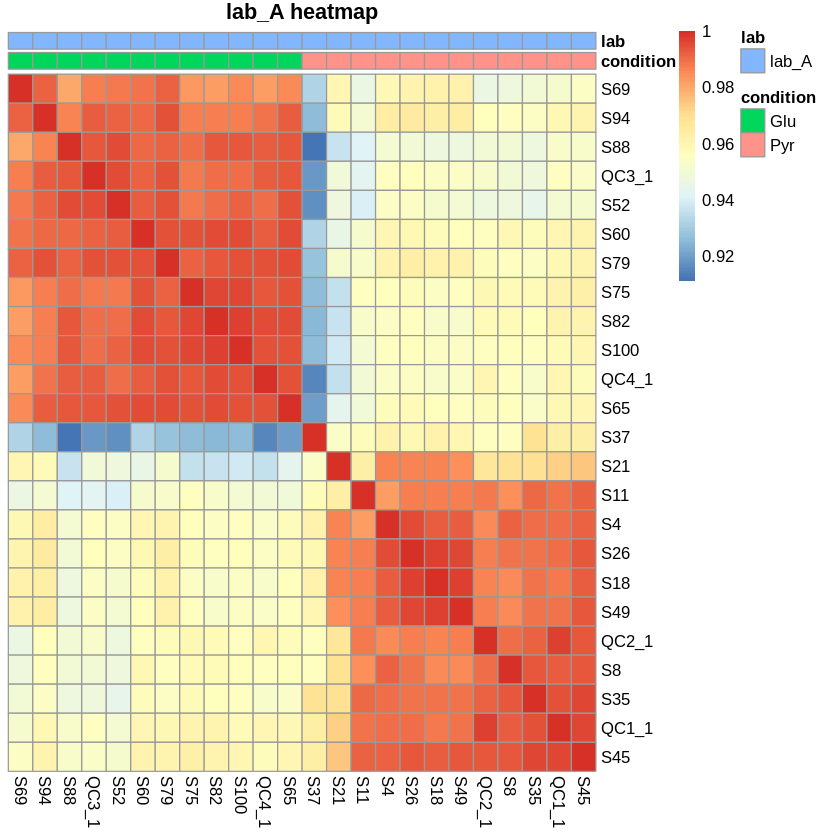

Number of proteins:  2820    Numer of samples:  23 
Filtering out features that have NAs in all columns
	Before filtering: 2820 23 
	After filtering: 2820 23 


`summarise()` has grouped output by 'Run'. You can override using the `.groups`
argument.
No id variables; using all as measure variables



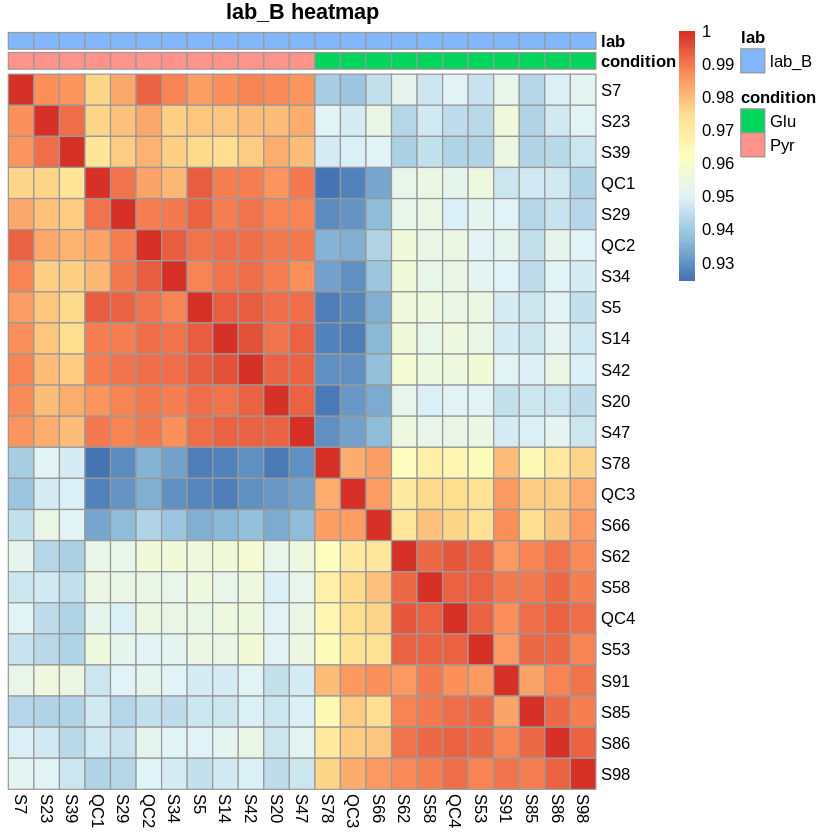

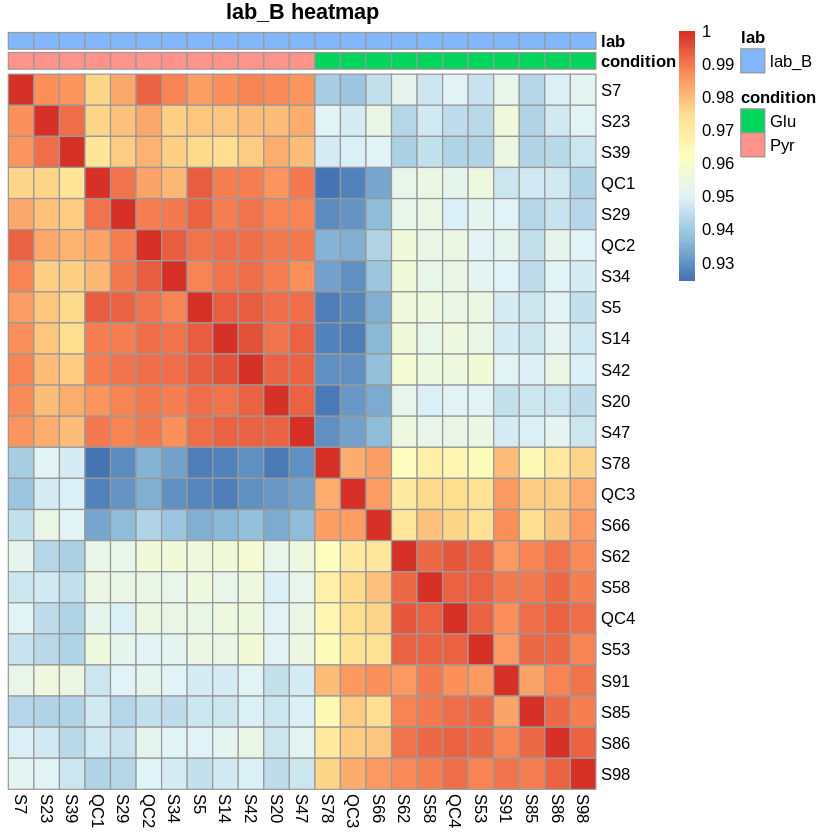

Number of proteins:  2813    Numer of samples:  24 
Filtering out features that have NAs in all columns
	Before filtering: 2813 24 
	After filtering: 2813 24 


`summarise()` has grouped output by 'Run'. You can override using the `.groups`
argument.
No id variables; using all as measure variables



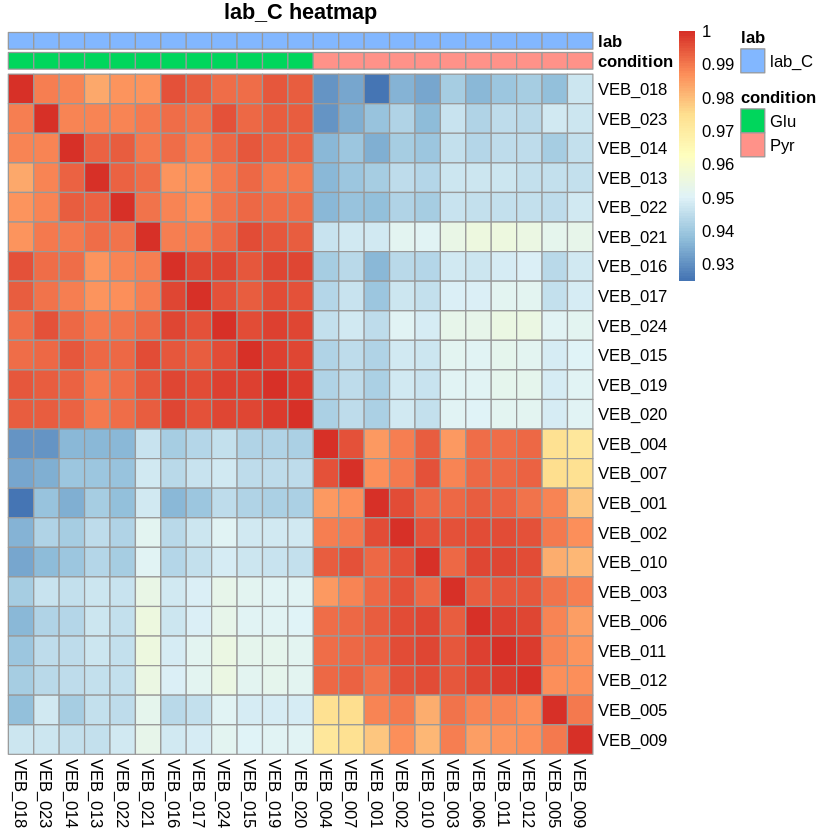

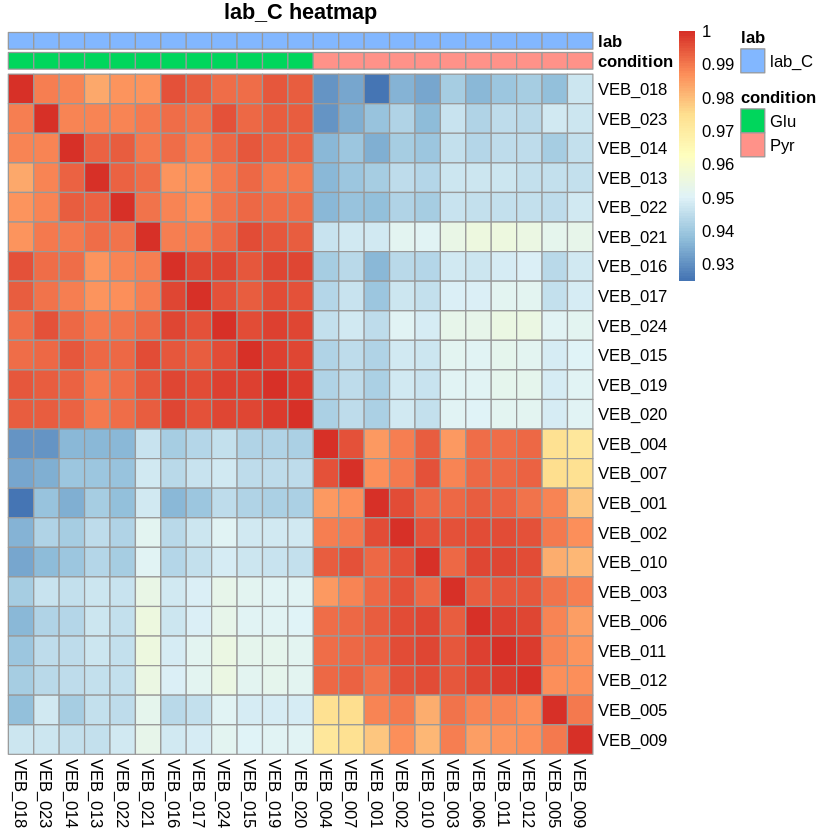

Number of proteins:  2401    Numer of samples:  24 
Filtering out features that have NAs in all columns
	Before filtering: 2401 24 
	After filtering: 2401 24 


`summarise()` has grouped output by 'Run'. You can override using the `.groups`
argument.
No id variables; using all as measure variables



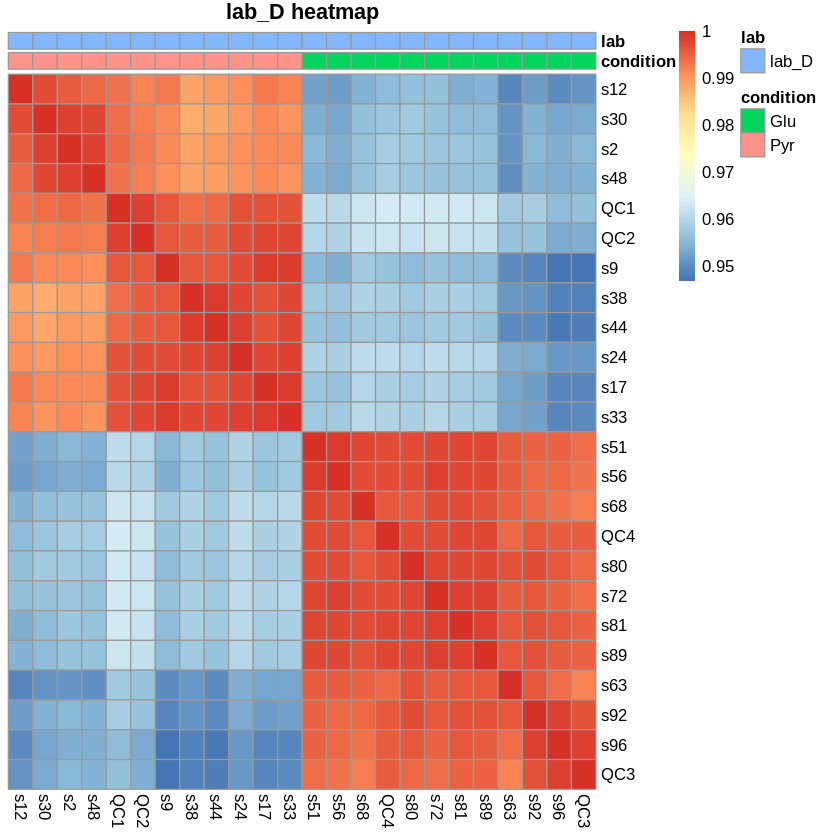

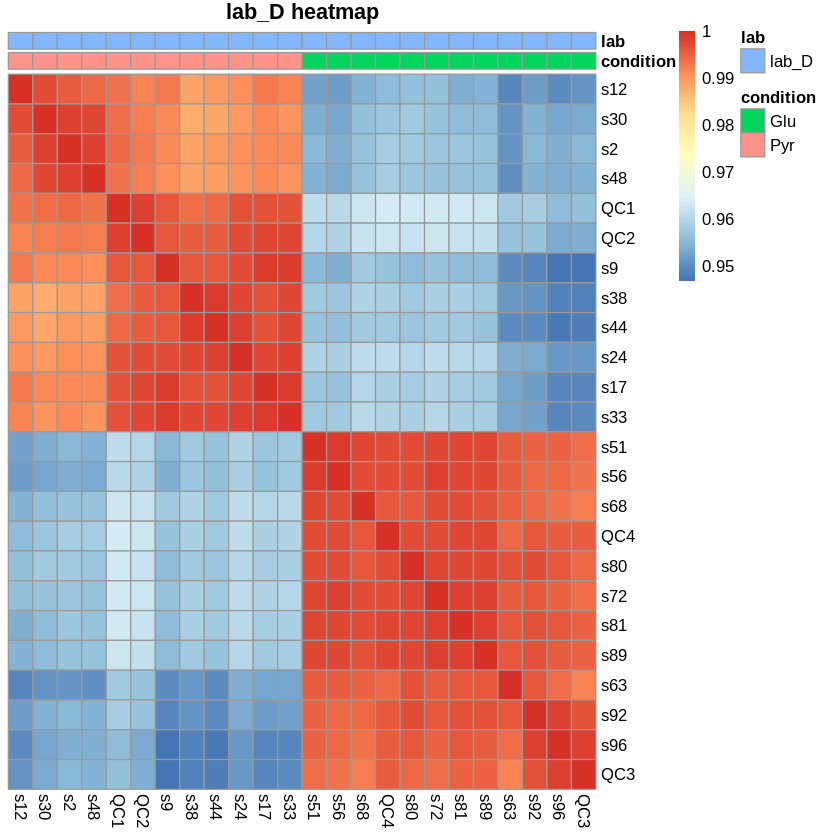

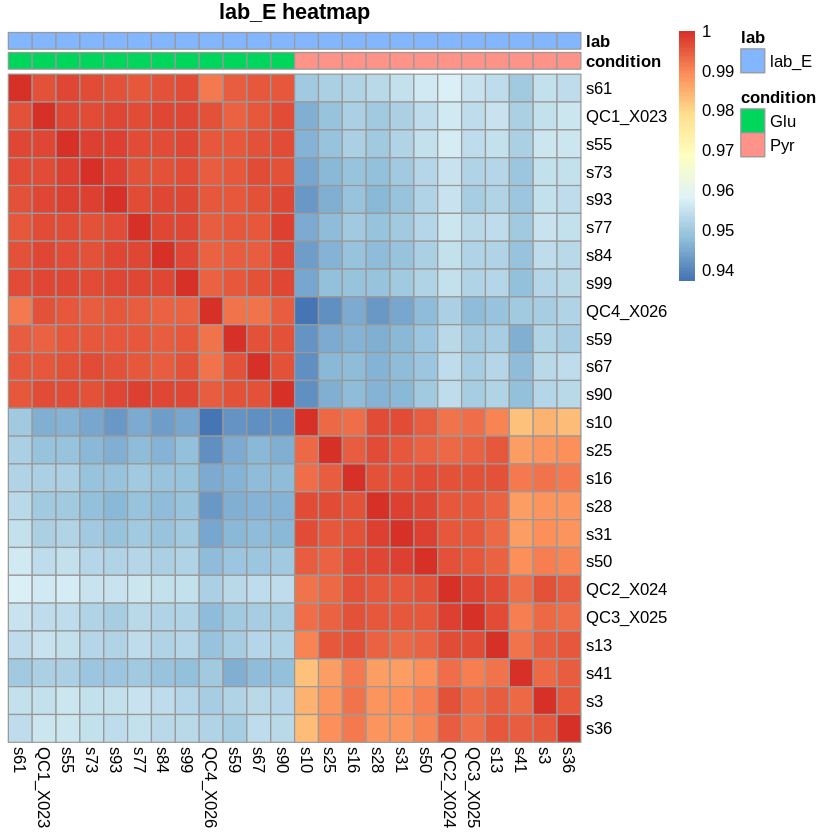

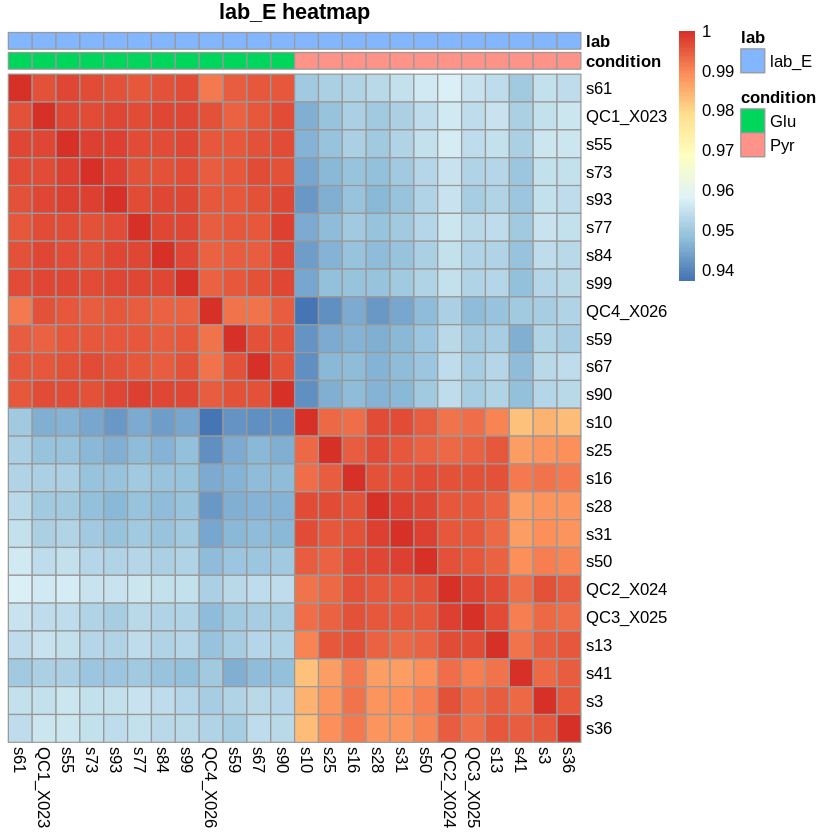

In [5]:
options(warn = -1)  
# metadata for centralized run
bath_info_all <- NULL

for (name in names(labs_list)) {
    lab_path <- labs_list[[name]]
    # check if we have lab results
    if (is.null(lab_path)) {next}
    # create plots file prefix
    plot_name_prefix <- paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/balanced/', name, '/', name)
    file_name_prefix <- paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/balanced/', name, "/")

    # read data
    data <- read_and_preprocc(lab_path, name)
    # create metadata file
    metadata <- create_metadata(data, name)
    write_tsv(metadata, paste0(file_name_prefix, "metadata.tsv"))

    # add  into metadata for centralized run
    if(is.null(bath_info_all)){
      bath_info_all <- metadata
    } else {
       bath_info_all <- rbind(bath_info_all, metadata)
    }

    # create design matrix for fedDEqMS
    dummy_df <- model.matrix(~condition - 1, metadata)
    colnames(dummy_df) <- gsub("condition", "", colnames(dummy_df))
    batch_info <- metadata %>% select(-condition) %>% cbind(dummy_df)
    write_tsv(batch_info %>% rownames_to_column(), 
              paste0(file_name_prefix, "design.tsv"))

    # create protein groups matrix
    # 0 are replaced with NA during preprocessing
    pg_matrix <- extract_pg_matrix(data)[, batch_info$file]
    cat("Number of proteins: ", dim(pg_matrix)[1], "   Numer of samples: ", dim(pg_matrix)[2], "\n")
    
    # apply basic filtering
    pg_matrix <- filter_na_proteins(pg_matrix, batch_info, 'file')
    write_tsv(pg_matrix %>% rownames_to_column(), 
              paste0(file_name_prefix, "protein_groups_matrix.tsv"))
    
    # create precursor counts table
    both_counts_table  <- get_pep_counts_table(data)
    summ_prec_counts_table <- both_counts_table[[1]]
    # prec_counts_table <- both_counts_table[[2]]
    write_tsv(summ_prec_counts_table %>% rownames_to_column(),
              paste0(file_name_prefix, "protein_counts.tsv"))

    # create plots
    create_plots(pg_matrix, metadata, name, plot_name_prefix)
}

write_tsv(bath_info_all %>% rownames_to_column(), 
          '/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/balanced/bath_info_all.tsv')
options(warn = 0)

Number of proteins:  2549    Numer of samples:  24   
Filtering out features that have NAs in all columns  
	- Before filtering: 2549 24   
	- After filtering: 2549 24  

Number of proteins:  2846    Numer of samples:  23  
Filtering out features that have NAs in all columns  
	- Before filtering: 2846 23   
	- After filtering: 2846 23   

Number of proteins:  2820    Numer of samples:  23  
Filtering out features that have NAs in all columns  
	- Before filtering: 2820 23  
	- After filtering: 2820 23  

Number of proteins:  2813    Numer of samples:  24  
Filtering out features that have NAs in all columns  
	- Before filtering: 2813 24  
	- After filtering: 2813 24  

Number of proteins:  2401    Numer of samples:  24  
Filtering out features that have NAs in all columns  
	- Before filtering: 2401 24  
	- After filtering: 2401 24  